# LEVEL 1 — Full-System Hemodynamics Validation
Goal: To verify that the entire cardiovascular system behaves physiologically:
- aortic pressure
- aortic flow
- cardiac output
- heart rate
- waveform periodicity
- comparison Abel_ref2 vs cow_runV23

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

RESULTS_DIR = "../projects/simple_run/results"

RUNS = {
    "Abel_ref2": "Abel_ref2",
    "cow_runV23": "cow_runV23",
}

P_FILE = "aorta.txt"
Q_FILE = "R_lv_aorta.txt"
G_FILE = "g.txt"

In [2]:
def load_ts(path):
    raw = open(path).read().splitlines()
    data = []
    for line in raw:
        line = line.replace(",", " ").replace(";", " ").strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) < 2:
            continue
        try:
            t = float(parts[0])
            v = float(parts[1])
            data.append([t, v])
        except:
            continue
    arr = np.array(data)
    return arr[:,0], arr[:,1]

def compute_level1_metrics(run_name):
    heart_dir = os.path.join(RESULTS_DIR, run_name, "heart_kim_lit")

    # load raw time series
    t_p, p_raw = load_ts(os.path.join(heart_dir, P_FILE))
    t_q, q_raw = load_ts(os.path.join(heart_dir, Q_FILE))

    # ground pressure (atmospheric)
    g_path = os.path.join(heart_dir, G_FILE)
    if os.path.exists(g_path):
        _, g = load_ts(g_path)
        p = p_raw - g
    else:
        p = p_raw - 1e5    # fallback as in FirstBlood

    # unit conversions
    p_mmHg = p / 133.322
    q_Lmin = q_raw * 60.0 * 1000.0

    # detect heartbeats
    peaks, _ = find_peaks(p_mmHg, distance=40)
    HR = np.nan
    if len(peaks) > 1:
        dt = np.diff(t_p[peaks]).mean()
        HR = 60.0 / dt

    # cardiac output = mean flow
    CO = np.mean(q_Lmin)

    # basic stats
    systolic  = np.max(p_mmHg)
    diastolic = np.min(p_mmHg)
    mean_p    = np.mean(p_mmHg)
    pulse_p   = systolic - diastolic

    # periodicity check: last 2 cycles
    if len(peaks) >= 3:
        i1, i2 = peaks[-3], peaks[-2]
        j1, j2 = peaks[-2], peaks[-1]
        seg1 = p_mmHg[i1:i2]
        seg2 = p_mmHg[j1:j2]
        m = min(len(seg1), len(seg2))
        periodicity_rms = np.sqrt(np.mean((seg1[:m] - seg2[:m])**2))
    else:
        periodicity_rms = np.nan

    return {
        "run": run_name,
        "SBP": systolic,
        "DBP": diastolic,
        "MAP": mean_p,
        "PulsePressure": pulse_p,
        "HR": HR,
        "CO": CO,
        "PeriodicityRMS": periodicity_rms,
        "t_p": t_p,
        "p_mmHg": p_mmHg,
        "t_q": t_q,
        "q_Lmin": q_Lmin,
    }


In [3]:
records = []

results = {}
for label, folder in RUNS.items():
    res = compute_level1_metrics(folder)
    results[label] = res
    records.append({
        "Run": label,
        "SBP (mmHg)": res["SBP"],
        "DBP (mmHg)": res["DBP"],
        "MAP (mmHg)": res["MAP"],
        "PulseP": res["PulsePressure"],
        "HR (bpm)": res["HR"],
        "CO (L/min)": res["CO"],
        "Periodicity RMS (mmHg)": res["PeriodicityRMS"],
    })

df_L1 = pd.DataFrame(records)
df_L1


,Run,SBP (mmHg),DBP (mmHg),MAP (mmHg),PulseP,HR (bpm),CO (L/min),Periodicity RMS (mmHg)
0,Abel_ref2,117.320097,1.090968,88.511163,116.229129,75.725705,4.728139,0.081709
1,cow_runV23,116.940940,1.090968,88.308495,115.849972,75.717741,4.730808,0.354100


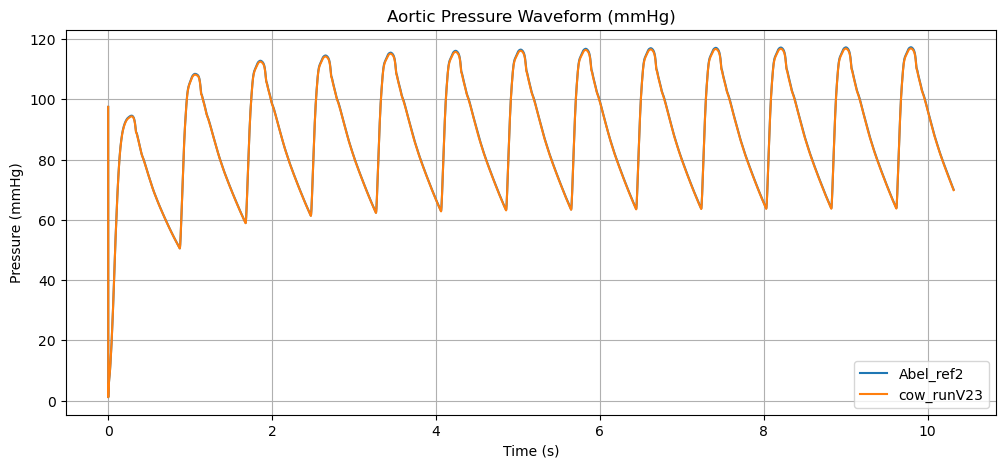

In [4]:
plt.figure(figsize=(12,5))

for label, res in results.items():
    plt.plot(res["t_p"], res["p_mmHg"], label=label)

plt.title("Aortic Pressure Waveform (mmHg)")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (mmHg)")
plt.grid(True)
plt.legend()
plt.show()


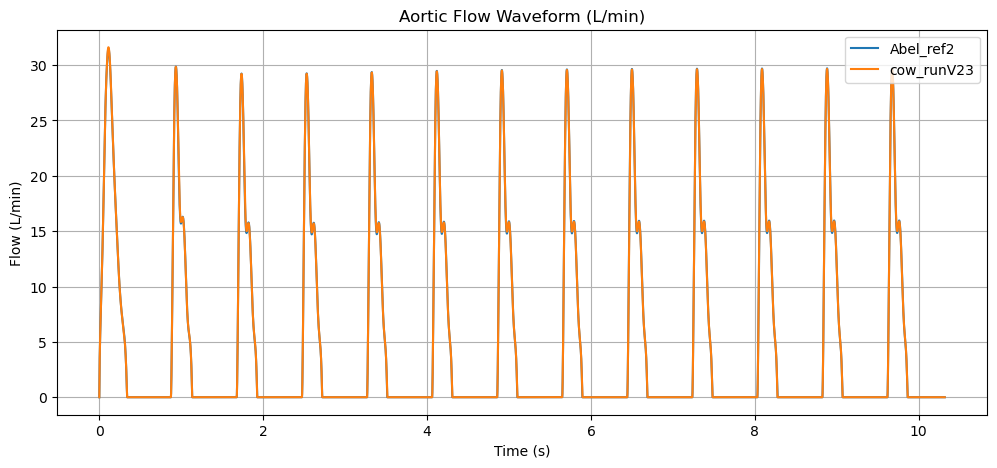

In [5]:
plt.figure(figsize=(12,5))

for label, res in results.items():
    plt.plot(res["t_q"], res["q_Lmin"], label=label)

plt.title("Aortic Flow Waveform (L/min)")
plt.xlabel("Time (s)")
plt.ylabel("Flow (L/min)")
plt.grid(True)
plt.legend()
plt.show()


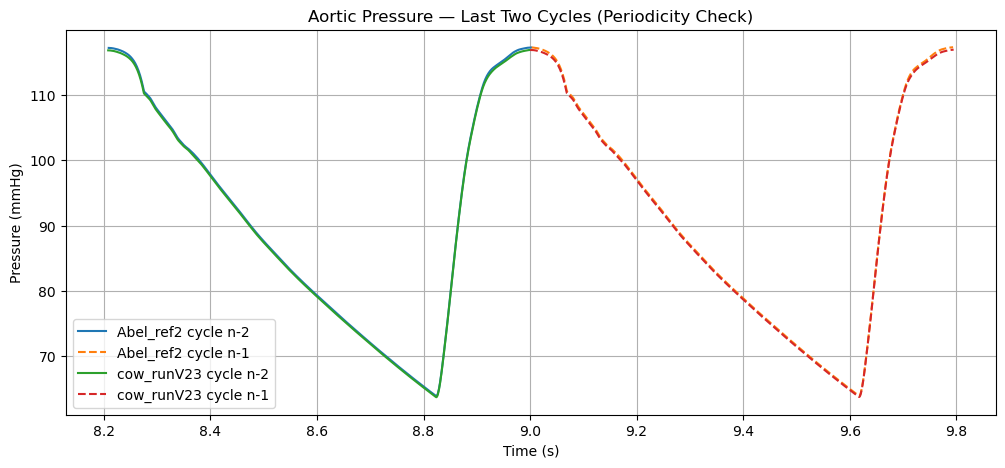

In [6]:
plt.figure(figsize=(12,5))

for label, res in results.items():
    p = res["p_mmHg"]
    t = res["t_p"]

    # detect cycles
    peaks, _ = find_peaks(p, distance=40)
    if len(peaks) < 3:
        continue

    # last two cycles
    i1, i2 = peaks[-3], peaks[-2]
    j1, j2 = peaks[-2], peaks[-1]

    plt.plot(t[i1:i2], p[i1:i2], label=f"{label} cycle n-2")
    plt.plot(t[j1:j2], p[j1:j2], '--', label=f"{label} cycle n-1")

plt.title("Aortic Pressure — Last Two Cycles (Periodicity Check)")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (mmHg)")
plt.grid(True)
plt.legend()
plt.show()


# LEVEL 2

In [8]:
from scipy.signal import find_peaks

# Mapping: anatomical label → probe folder (pXX)
COW_TERMINALS = {
    "R_P2"     : "p36",
    "L_P2"     : "p33",
    "R_A2"     : "p38",
    "L_A2"     : "p31",
    "R_M2_sup" : "p39",
    "R_M2_inf" : "p40",
    "L_M2_sup" : "p30",
    "L_M2_inf" : "p29",
}

RIGHT = ["R_P2", "R_A2", "R_M2_sup", "R_M2_inf"]
LEFT  = ["L_P2", "L_A2", "L_M2_sup", "L_M2_inf"]

MCA = ["R_M2_sup", "R_M2_inf", "L_M2_sup", "L_M2_inf"]
ACA = ["R_A2", "L_A2"]
PCA = ["R_P2", "L_P2"]

def integrate_one_cycle(time, signal):
    """
    Integrate flow over ONE cardiac cycle.
    Returns:
      stroke_volume (solver units),
      period (s)
    """
    peaks, _ = find_peaks(signal, distance=40)
    if len(peaks) < 2:
        raise RuntimeError("Not enough peaks to detect a cardiac cycle")

    i1, i2 = peaks[0], peaks[1]
    t_seg = time[i1:i2+1]
    q_seg = signal[i1:i2+1]

    vol = np.trapezoid(q_seg, t_seg)  # stroke volume in solver units
    period = t_seg[-1] - t_seg[0]
    return vol, period


In [9]:
def analyze_level2_brain_split(run_name):
    """
    Level-2 analysis:
      - stroke volume at each CoW terminal (Q1.txt)
      - normalized by total brain stroke volume
      - hemispheric and territory fractions

    Returns:
      df (DataFrame with stroke_vol & brain_fraction),
      summary (dict with hemisphere & territory fractions, total_brain_vol, period)
    """
    base = os.path.join(RESULTS_DIR, run_name)

    rows = []
    period_first = None

    for label, pid in COW_TERMINALS.items():
        folder = os.path.join(base, pid)
        q_path = os.path.join(folder, "Q1.txt")

        if not os.path.exists(q_path):
            print(f"[WARN] Missing {q_path}, skipping {label}")
            continue

        t, q = load_ts(q_path)
        vol, period = integrate_one_cycle(t, q)

        if period_first is None:
            period_first = period

        rows.append({"label": label, "pid": pid, "stroke_vol": vol})

    df = pd.DataFrame(rows).set_index("label")
    total_brain_vol = df["stroke_vol"].sum()
    df["brain_fraction"] = df["stroke_vol"] / total_brain_vol

    # Hemisphere fractions
    right_frac = df.loc[RIGHT, "brain_fraction"].sum()
    left_frac  = df.loc[LEFT, "brain_fraction"].sum()

    # Territory fractions
    mca_frac = df.loc[MCA, "brain_fraction"].sum()
    aca_frac = df.loc[ACA, "brain_fraction"].sum()
    pca_frac = df.loc[PCA, "brain_fraction"].sum()

    print(f"\n=== LEVEL 2 — brain split (run: {run_name}) ===")
    print(f"One cardiac period (from first terminal): {period_first:.3f} s")
    print(f"Total 'brain stroke volume' (solver units): {total_brain_vol:.3e}\n")
    display(df[["pid", "stroke_vol", "brain_fraction"]])

    print("\n--- Hemispheric split (fraction of brain inflow) ---")
    print(f"Right hemisphere: {100*right_frac:.2f}% of brain inflow")
    print(f"Left hemisphere : {100*left_frac:.2f}% of brain inflow")
    print("(Expected: roughly 50/50 unless variant causes asymmetry.)")

    print("\n--- Territory split (fraction of brain inflow) ---")
    print(f"MCA: {100*mca_frac:.2f}% of brain inflow")
    print(f"ACA: {100*aca_frac:.2f}% of brain inflow")
    print(f"PCA: {100*pca_frac:.2f}% of brain inflow")
    print("Expected qualitatively: MCA > ACA > PCA.")

    summary = {
        "run": run_name,
        "period": period_first,
        "total_brain_vol": total_brain_vol,
        "right_frac": right_frac,
        "left_frac": left_frac,
        "mca_frac": mca_frac,
        "aca_frac": aca_frac,
        "pca_frac": pca_frac,
    }
    return df, summary


In [10]:
level2_results = {}
summaries = []

for label, folder in RUNS.items():
    df, summary = analyze_level2_brain_split(folder)
    level2_results[label] = df
    summaries.append(summary)

df_L2_summary = pd.DataFrame(summaries)
df_L2_summary



=== LEVEL 2 — brain split (run: Abel_ref2) ===
One cardiac period (from first terminal): 0.759 s
Total 'brain stroke volume' (solver units): 6.062e+05



,pid,stroke_vol,brain_fraction
label,,,
R_P2,p36,77896.956500,0.128498
L_P2,p33,77792.221140,0.128326
R_A2,p38,79611.294030,0.131326
L_A2,p31,79709.160640,0.131488
R_M2_sup,p39,72853.845655,0.120179
R_M2_inf,p40,72859.246890,0.120188
L_M2_sup,p30,72740.758060,0.119993
L_M2_inf,p29,72746.113620,0.120002



--- Hemispheric split (fraction of brain inflow) ---
Right hemisphere: 50.02% of brain inflow
Left hemisphere : 49.98% of brain inflow
(Expected: roughly 50/50 unless variant causes asymmetry.)

--- Territory split (fraction of brain inflow) ---
MCA: 48.04% of brain inflow
ACA: 26.28% of brain inflow
PCA: 25.68% of brain inflow
Expected qualitatively: MCA > ACA > PCA.

=== LEVEL 2 — brain split (run: cow_runV23) ===
One cardiac period (from first terminal): 0.788 s
Total 'brain stroke volume' (solver units): 4.800e+05



,pid,stroke_vol,brain_fraction
label,,,
R_P2,p36,81090.635570,0.168954
L_P2,p33,36263.516603,0.075556
R_A2,p38,35653.455436,0.074285
L_A2,p31,35653.832901,0.074285
R_M2_sup,p39,72746.116925,0.151568
R_M2_inf,p40,72854.039630,0.151793
L_M2_sup,p30,72845.193140,0.151774
L_M2_inf,p29,72850.566215,0.151785



--- Hemispheric split (fraction of brain inflow) ---
Right hemisphere: 54.66% of brain inflow
Left hemisphere : 45.34% of brain inflow
(Expected: roughly 50/50 unless variant causes asymmetry.)

--- Territory split (fraction of brain inflow) ---
MCA: 60.69% of brain inflow
ACA: 14.86% of brain inflow
PCA: 24.45% of brain inflow
Expected qualitatively: MCA > ACA > PCA.


,run,period,total_brain_vol,right_frac,left_frac,mca_frac,aca_frac,pca_frac
0,Abel_ref2,0.759,606209.596535,0.500192,0.499808,0.480362,0.262814,0.256824
1,cow_runV23,0.788,479957.356420,0.546599,0.453401,0.606920,0.148570,0.244510
